# Illustrating Model Properties

Roman Ludwig [](https://orcid.org/0000-0001-9434-328X) (University of Zurich, University Hospital Zurich)  
Yoel Perez Haas (University of Zurich, University Hospital Zurich)  
Jan Unkelbach [](https://orcid.org/0000-0002-4275-990X) (University of Zurich, University Hospital Zurich)

# Diagnose Time Prior and Evolution of Midline Extension

First, we illustrate how the prior distribution over diagnose times and the conditional distribution of having developed a tumor that crosses the mid-sagittal line *given* a diagnosis time evolve together.

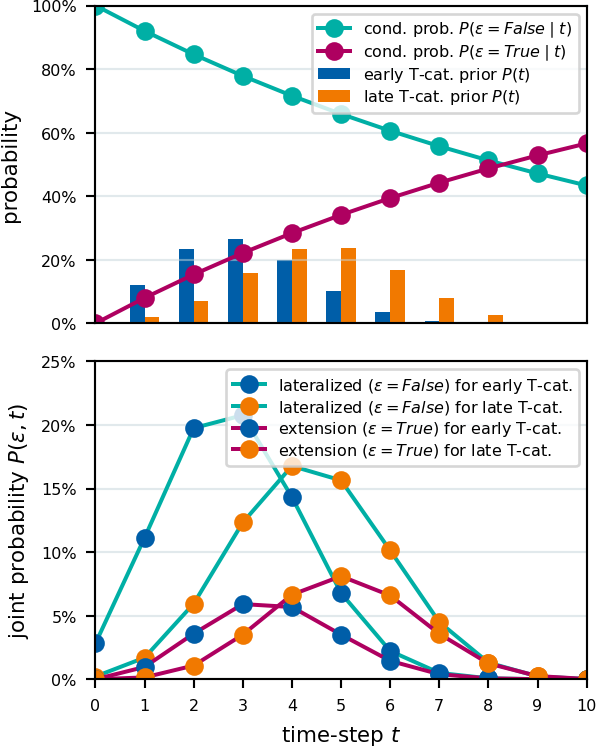

In [2]:
#| label: fig-model-midext-evo
#| fig-cap: "The top panel shows the prior probability to get diagnosed at time-step $t$ for early and late T-category tumors as bars. Also in the top panel, we plot the conditional probability of the tumor's midline extension ($\epsilon=\texttt{True}$), given the time-step $t$ as a line plot. In the bottom panel, we show the joint probability of getting diagnosed in time-step $t$ *and* having a tumor that crosses the midline."
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import ticker
from lyscripts.plot.utils import COLORS
from scripts import shared, paths

model = shared.get_model("simple", load_samples=True)

t = np.linspace(0, 10, 11)
p_midline = {
  "lateralized": (1 - model.midext_prob)**t,
  "extension": 1 - (1 - model.midext_prob)**t,
}
dist = {
  "early": model.get_distribution("early").pmf,
  "late": model.get_distribution("late").pmf,
}
p_colors = {"lateralized": COLORS["green"], "extension": COLORS["red"]}
t_colors = {"early": COLORS["blue"], "late": COLORS["orange"]}
markers = {}

nrows, ncols = 2, 1
plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  width=17/2,
))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
w = 0.3

for label, p in p_midline.items():
  axes[0].plot(
    t, p_midline[label], "o-",
    label=f"cond. prob. $P(\epsilon={label=='extension'} \mid t)$",
    color=p_colors[label],
  )
  for i, t_stage in enumerate(["early", "late"]):
    if label == "lateralized":
      axes[0].bar(
        t + i*w - w/2, dist[t_stage],
        color=t_colors[t_stage],
        width=w,
        label=f"{t_stage} T-cat. prior $P(t)$",
      )
    axes[1].plot(
      t, p * dist[t_stage], "o-",
      c=p_colors[label],
      mfc=t_colors[t_stage],
      mec=t_colors[t_stage],
      label=f"{label} ($\epsilon={label=='extension'}$) for {t_stage} T-cat.",
    )

axes[0].set_ylim(0., 1.)
axes[0].tick_params(bottom=False, labelbottom=False)
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[0].set_ylabel("probability")
axes[0].grid(axis="y", color=COLORS["gray"], alpha=0.5)

axes[0].legend(labelspacing=0.2)

axes[1].set_xlim(min(t), max(t))
axes[1].set_xticks(t)
axes[1].set_xlabel("time-step $t$")

axes[1].set_ylim(0., 0.25)
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
axes[1].set_ylabel("joint probability $P(\epsilon, t)$")
axes[1].grid(axis="y", color=COLORS["gray"], alpha=0.5)

axes[1].legend(labelspacing=0.2)

plt.savefig(paths.figure_dir / "fig-model-midext-evo.svg")
plt.show()

# Sampling History

For bookeeping, we also show how different quantities evolve during the burnin of the sampling. For example, the ratio of proposed samples that were accepted or the autocorrelation time.

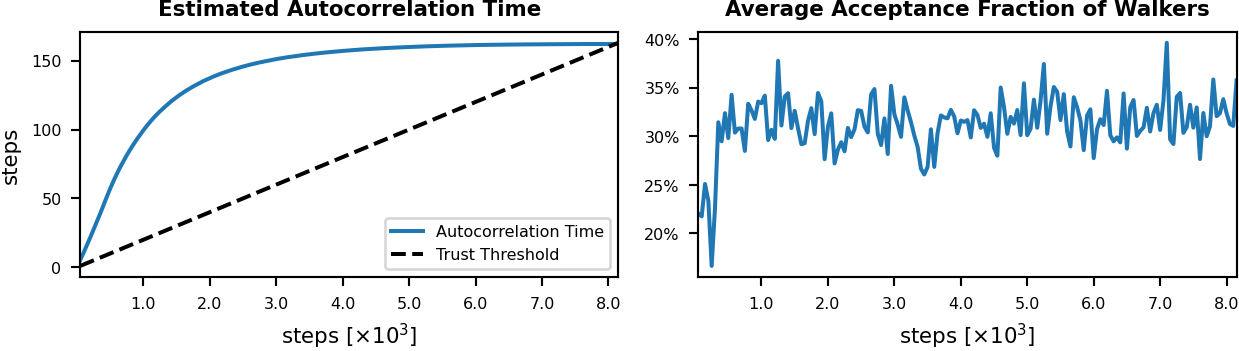

In [3]:
#| echo: false
#| label: fig-model-burnin-history
#| fig-cap: Monitoring quantities during the burn-in phase of the parameter sampling.
from collections import namedtuple
import pandas as pd
from scripts import shared, paths
import matplotlib.pyplot as plt
from matplotlib import ticker

params = shared.get_params()

def custom(x, pos):
  return "{:.1f}".format(x/1000)

PlotConfig = namedtuple("PlotConfig", ["title", "ylabel", "label"])

nrows, ncols = 1, 2
config_map = {
  "acor_times": PlotConfig(
    title="Estimated Autocorrelation Time",
    ylabel="steps",
    label="Autocorrelation Time",
  ),
  "accept_fracs": PlotConfig(
    title="Average Acceptance Fraction of Walkers",
    ylabel=None,
    label=None,
  ),
}

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  width=17,
))

fig, axes = plt.subplots(
  nrows=nrows,
  ncols=ncols,
  sharex=True,
)

for model in ["full"]:
  history = pd.read_csv(f"models/{model}/history.csv").set_index("steps")
  for i, (column, config) in enumerate(config_map.items()):
    axes[i].set_title(config.title, fontweight="bold")
    axes[i].plot(history.index, history[column], label=config.label)
    axes[i].autoscale(enable=True, tight=True, axis="x")
    axes[i].set_ylabel(config.ylabel)
    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(custom))
    axes[i].set_xlabel(r"steps [$\times 10^3$]")

axes[0].plot(
  history.index,
  history.index / params["sampling"]["trust_fac"],
  "--",
  color="black",
  label="Trust Threshold",
)
axes[0].legend()
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))

plt.savefig(paths.figure_dir / "fig-model-burnin-history.svg")
plt.show()

# Prior State Distribution of Midline Model

It may be illustrative to look at the 3D state distribution of the midline model (at least if we only consider 3 LNLs).

/tmp/ipykernel_162345/2134411740.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(paths.figure_dir / "fig-model-state-dist.svg")
/home/rmnldwg/repos/bilateral-paper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)

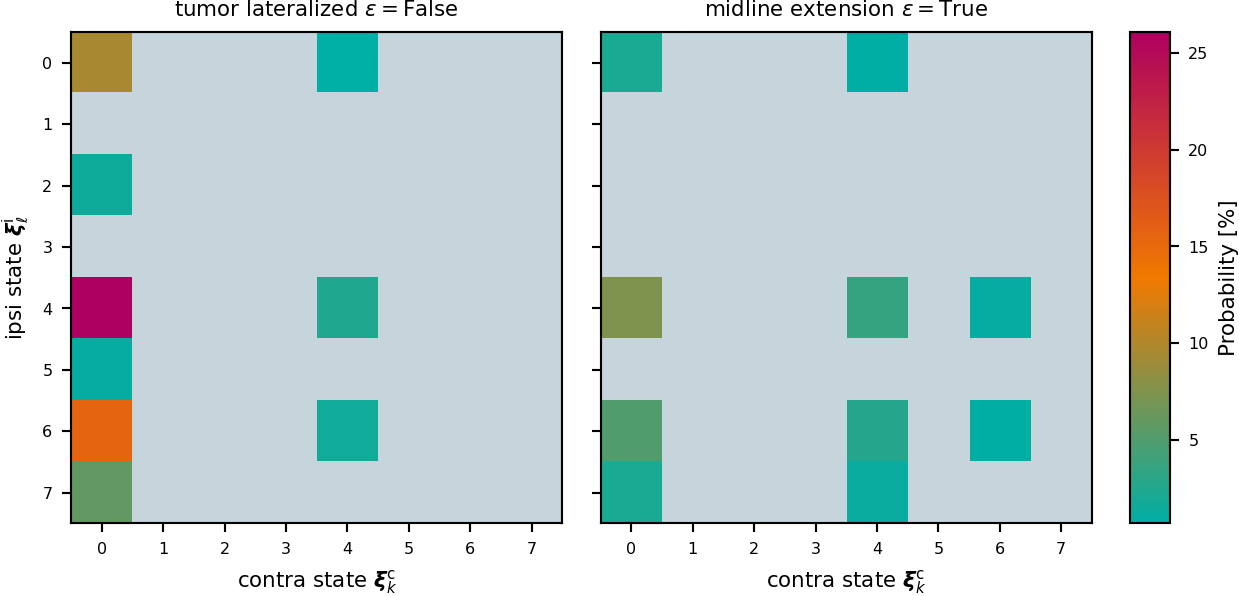

In [4]:
#| label: fig-model-state-dist
#| fig-cap: '3D state distribution of a midline model with 3 LNLs (II, III, and IV) in both sides of the neck.'
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid
from lyscripts.plot.utils import COLORS
from scripts import shared, paths

model = shared.get_model(which="simple", load_samples=True)
state_dist = 100 * model.state_dist(t_stage="late")
vmin, vmax = np.min(state_dist), np.max(state_dist)

nrows, ncols = 1, 2
cmap = LinearSegmentedColormap.from_list(
  name="usz",
  colors=[COLORS["green"], COLORS["orange"], COLORS["red"]],
)
cmap.set_under(COLORS["gray"])

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=1.,
  width=17,
))

fig = plt.figure()
grid = AxesGrid(
  fig, 111,
  nrows_ncols=(nrows, ncols),
  axes_pad=0.2,
  share_all=True,
  cbar_location="right",
  cbar_mode="single",
  cbar_size="8%"
)
noext, midext = grid

im = noext.imshow(state_dist[0], cmap=cmap, vmin=100 * np.exp(-5), vmax=vmax)
im = midext.imshow(state_dist[1], cmap=cmap, vmin=100 * np.exp(-5), vmax=vmax)
grid.cbar_axes[0].colorbar(im)
grid.cbar_axes[0].set_ylabel("Probability [%]")

noext.set_title(r"tumor lateralized $\epsilon=\text{False}$")
midext.set_title(r"midline extension $\epsilon=\text{True}$")

noext.set_ylabel(r"ipsi state $\boldsymbol{\xi}^\text{i}_\ell$")
noext.set_xlabel(r"contra state $\boldsymbol{\xi}^\text{c}_k$")
midext.set_xlabel(r"contra state $\boldsymbol{\xi}^\text{c}_k$")

plt.savefig(paths.figure_dir / "fig-model-state-dist.svg")
plt.show()

# Observed vs Predicted Prevalence

To verify that the model does what it is supposed to, we compare how often some selected diagnoses appear in the data and how often the model predicts these diagnoses to be observed.

## Contralteral LNLs II, III, and IV Dependent on T-Cat. and Mid. Ext.

We start witht the most commonly involved LNLs in the contralateral neck: II, III, and IV. We investigate their prevalence in the four scenarios early T-cat. withour mid. ext, late T-cat. without mid. ext., early T-cat. with mid. ext., and late T-cat. with mid. ext.

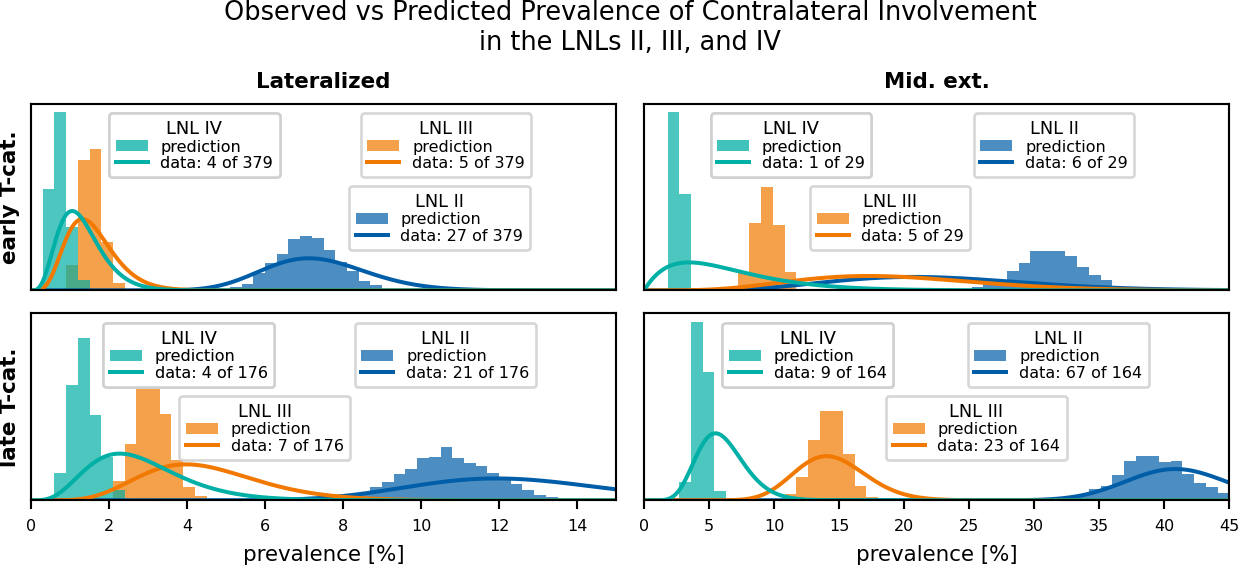

In [5]:
#| label: fig-model-prevalences-overall
#| fig-cap: 'Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown for the contralateral LNLs II (blue), III (orange), and IV (green). The top row shows scenarios with early T-category tumors, the bottom row for late T-category ones. The left column depicts scenarios where the primary tumor is clearly lateralized, the right column scenarios of tumors extending over the mid-sagittal line. This figure illustrates the model''s ability to describe the prevalence of different combinations of scenarios involving the risk factors T-category and midline extension.'
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS, split_legends
from scripts import paths, shared

def turn_axis_off(axes):
  axes.set_xticks([])
  axes.set_yticks([])

nrows, ncols = 2, 2

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=2.,
  width=17,
))

fig = plt.figure()
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)
axes = np.array([[fig.add_subplot(gs[i,j]) for j in range(ncols)] for i in range(nrows)])
full = fig.add_subplot(gs[:,:], frame_on=False)
turn_axis_off(full)

full.set_title(
  "Observed vs Predicted Prevalence of Contralateral Involvement\nin the LNLs II, III, and IV",
  pad=20.,
  fontsize="large",
)

data = shared.get_data()

for i, t_stage in enumerate(["early", "late"]):
  axes[i,0].set_ylabel(f"{t_stage} T-cat.", fontweight="bold")
  for j, midext in enumerate([False, True]):
    axes[0,j].set_title("Mid. ext." if midext else "Lateralized", fontweight="bold")
    axes[0,j].set_xticks([])
    axes[-1,j].set_xlabel("prevalence [%]")
    axes[i,j].set_yticks([])
    content = []
    for lnl, color in zip(
      ["II", "III", "IV"],
      [COLORS["blue"], COLORS["orange"], COLORS["green"]],
    ):
      scenario = Scenario(
        t_stages=[t_stage],
        midext=midext,
        diagnosis={"contra": {"max_llh": {lnl: True}}}
      )
      content.append(
        Histogram.from_hdf5(
          filename=paths.model_dir / "full" / "prevalences_overall.hdf5",
          dataname=scenario.md5_hash("prevalences"),
          color=color,
          label="prediction",
        )
      )
      content.append(
        BetaPosterior.from_hdf5(
          filename=paths.model_dir / "full" / "prevalences_overall.hdf5",
          dataname=scenario.md5_hash("prevalences"),
          color=color,
        )
      )
    draw(
      axes=axes[i,j],
      contents=content,
      xlims=(0., 15. if not midext else 45.),
    )

# manually place legends
split_legends(
  axes=axes[0,0],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.53, 0.6), (0.55, 0.99), (0.12, 0.99)],
)
split_legends(
  axes=axes[0,1],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.55, 0.99), (0.27, 0.6), (0.1, 0.99)],
)
axes[1,0].set_ylim(top=1.4)
split_legends(
  axes=axes[1,0],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.54, 0.99), (0.24, 0.6), (0.11, 0.99)],
)
split_legends(
  axes=axes[1,1],
  titles=["LNL II", "LNL III", "LNL IV"],
  locs=[(0.54, 0.99), (0.4, 0.6), (0.12, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-overall.svg")
plt.show()

## Correlation between Ipsi- and Contralateral Involvement

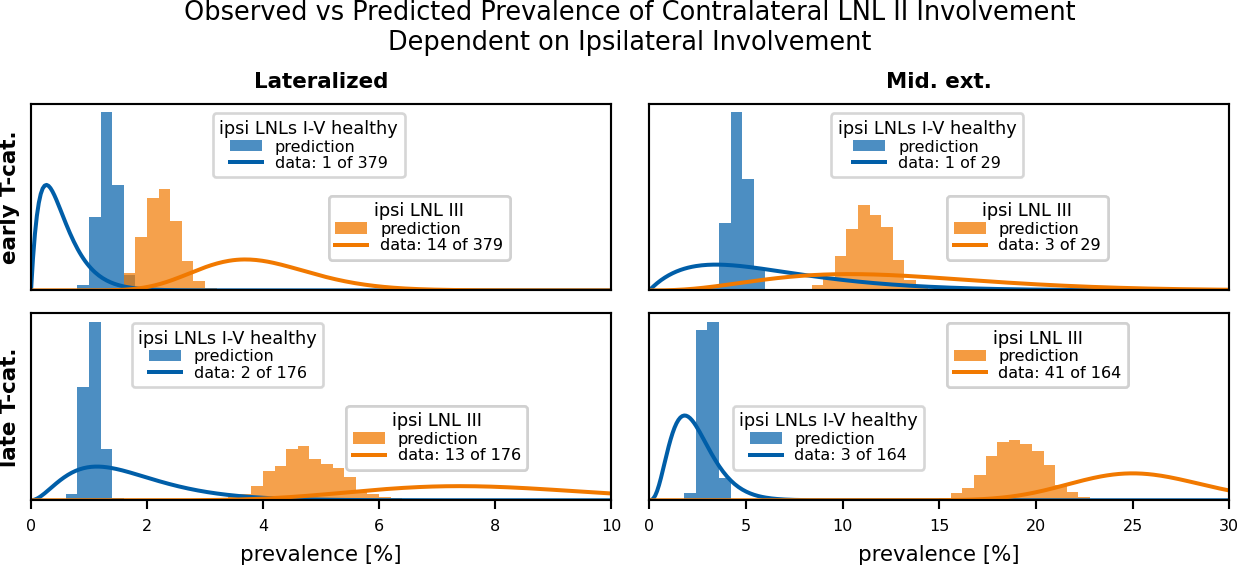

In [6]:
#| label: fig-model-prevalences-with-ipsi
#| fig-cap: 'Comparison of predicted (histograms) vs observed (beta posteriors) prevalences. Shown are four scenarios, all including contralateral LNL II involvement: Early T-category and an ipsilateral N0 neck (green), early T-category and ipsilateral LNL II involvement (blue), as well as the same two scenarios but for advanced T-category (orange and red). The figure shows that the model is capable of describing the correlation between ipsi- and contralateral involvement. Although for the scenario of LNL II involvement in both sides, the prediction''s split between early and advanced T-category is not large enough.'
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS, split_legends
from scripts import paths, shared

def turn_axis_off(axes):
  axes.set_xticks([])
  axes.set_yticks([])

nrows, ncols = 2, 2

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=2.,
  width=17,
))

fig = plt.figure()
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)
axes = np.array([[fig.add_subplot(gs[i,j]) for j in range(ncols)] for i in range(nrows)])
full = fig.add_subplot(gs[:,:], frame_on=False)
turn_axis_off(full)

full.set_title(
  "Observed vs Predicted Prevalence of Contralateral LNL II Involvement\nDependent on Ipsilateral Involvement",
  pad=20.,
  fontsize="large",
)

data = shared.get_data()

for i, t_stage in enumerate(["early", "late"]):
  axes[i,0].set_ylabel(f"{t_stage} T-cat.", fontweight="bold")
  for j, midext in enumerate([False, True]):
    axes[0,j].set_title("Mid. ext." if midext else "Lateralized", fontweight="bold")
    axes[0,j].set_xticks([])
    axes[-1,j].set_xlabel("prevalence [%]")
    axes[i,j].set_yticks([])
    content = []
    for ipsi, color in zip(
      [{"I": False, "II": False, "III": False, "IV": False, "V": False}, {"III": True}],
      [COLORS["blue"], COLORS["orange"]],
    ):
      scenario = Scenario(
        t_stages=[t_stage],
        midext=midext,
        diagnosis={
          "ipsi": {"max_llh": ipsi},
          "contra": {"max_llh": {"II": True}},
        }
      )
      content.append(
        Histogram.from_hdf5(
          filename=paths.model_dir / "full" / "prevalences_with_ipsi.hdf5",
          dataname=scenario.md5_hash("prevalences"),
          color=color,
          label="prediction",
        )
      )
      content.append(
        BetaPosterior.from_hdf5(
          filename=paths.model_dir / "full" / "prevalences_with_ipsi.hdf5",
          dataname=scenario.md5_hash("prevalences"),
          color=color,
        )
      )
    draw(
      axes=axes[i,j],
      contents=content,
      xlims=(0., 30. if midext else 10.),
    )

# manually place legends
split_legends(
  axes=axes[0,0],
  titles=["ipsi LNLs I-V healthy", "ipsi LNL III"],
  locs=[(0.3, 0.99), (0.5, 0.55)],
)
split_legends(
  axes=axes[0,1],
  titles=["ipsi LNLs I-V healthy", "ipsi LNL III"],
  locs=[(0.3, 0.99), (0.5, 0.55)],
)
split_legends(
  axes=axes[1,0],
  titles=["ipsi LNLs I-V healthy", "ipsi LNL III"],
  locs=[(0.16, 0.99), (0.53, 0.55)],
)
split_legends(
  axes=axes[1,1],
  titles=["ipsi LNLs I-V healthy", "ipsi LNL III"],
  locs=[(0.13, 0.55), (0.5, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-with-ipsi.svg")
plt.show()

## Portion of Midline Extension

Since we model the tumor’s midline extension as a random variable we can predict its portion among early or late T-category patients and compare it with the observed prevalence in the data.

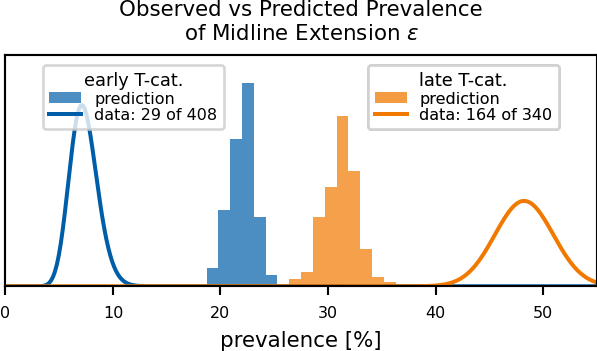

In [7]:
#| label: fig-model-prevalences-midext
#| fig-cap: 'Comparing the predicted (histograms) and observed (lines depicting beta posteriors) prevalence of midline extension for early (blue) and late (orange) T-category. While the prevalence is predicted correctly when marginalizing over T-category, the model cannot capture the degree of separation observed in the data. Since the tumor''s midline extension is virtually always part of the diagnosis and hence *given* when predicting a patient''s risk, we do not consider this discrepancy a major issue.'
import matplotlib.pyplot as plt
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, BetaPosterior, draw, COLORS, split_legends
from scripts import paths, shared
from scripts.marginalize_midext import possible_combinations, SummedBetaPosterior

plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(width=17./2.))

fig, ax = plt.subplots()
content = []
colors = iter([COLORS[c] for c in ["blue", "orange"]])

data = shared.get_data()
has_unknown_midext = data.ly.midext.isna()

for t_stage in ["early", "late"]:
  has_t_stage = data.ly.t_stage.isin([t_stage])
  scenario = Scenario(
    t_stages=[t_stage],
    midext=True,
    diagnosis={"ipsi": {"max_llh": {"II": None}}},
  )
  unknowns = (has_unknown_midext & has_t_stage).sum()
  color = next(colors)
  content.append(
    Histogram.from_hdf5(
      filename=paths.model_dir / "full" / "prevalences_midext.hdf5",
      dataname=t_stage,
      color=color,
      label="prediction"
    )
  )
  content.append(
    BetaPosterior.from_hdf5(
      filename=paths.model_dir / "full" / "prevalences_midext.hdf5",
      dataname=t_stage,
      color=color,
    )
  )

draw(ax, content, xlims=(0., 55.))
ax.set_title("Observed vs Predicted Prevalence\nof Midline Extension $\epsilon$")
ax.set_yticks([])
ax.set_ylim(top=0.4)
ax.set_xlabel("prevalence [%]")

split_legends(
  axes=ax,
  titles=["early T-cat.", "late T-cat."],
  locs=[(0.05, 0.99), (0.6, 0.99)],
)

plt.savefig(paths.figure_dir / "fig-model-prevalences-midext.svg")
plt.show()

# Risk Predictions

Now, we want to make actual use of the model and predict the risk for occult diease given some diagnoses.

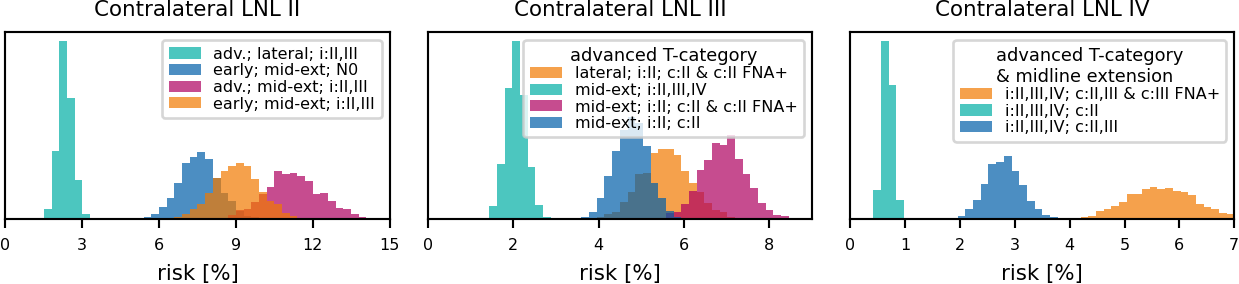

In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from lyscripts.scenario import Scenario
from lyscripts.plot.utils import Histogram, draw, COLORS, split_legends
from scripts import paths, shared

nrows, ncols = 1, 3
plt.rcParams.update(shared.get_fontsizes())
plt.rcParams.update(shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  width=17,
  aspect_ratio=1.3,
))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

contents = {"II": [], "III": [], "IV": []}
mean_lists = {"II": [], "III": [], "IV": []}
defaults = {
  "density": True,
  "histtype": "stepfilled",
  "alpha": 0.7,
  "bins": 50,
}
t_stage_map = {"early": "early", "late": "adv."}
midext_map = {False: "lateral", True: "mid-ext"}
colors = [COLORS["green"], COLORS["blue"], COLORS["orange"], COLORS["red"]]


def get_diag_label(diagnosis) -> str:
  label = ""
  is_n0 = True

  ipsi_positive = [lnl for lnl, status in diagnosis.get("ipsi", {}).get("CT", {}).items() if status]
  if len(ipsi_positive) > 0:
    is_n0 = False
    label += "i:" + ",".join(ipsi_positive)

  contra_positive = [lnl for lnl, status in diagnosis.get("contra", {}).get("CT", {}).items() if status]
  if len(contra_positive) > 0:
    is_n0 = False
    label += "; c:" + ",".join(contra_positive)

  return label if not is_n0 else "N0"

def get_label(scenario: Scenario) -> str:
  lnl = list(eval(scenario.involvement)["contra"].keys()).pop()
  d = eval(scenario.diagnosis)
  has_upstream_fna = "FNA" in d["contra"]

  if lnl == "IV":
    return get_diag_label(d) + (" & c:III FNA+" if has_upstream_fna else "")

  m = scenario.midext

  if lnl == "III":
    return f"{midext_map[m]}; {get_diag_label(d)}" + (" & c:II FNA+" if has_upstream_fna else "")

  t = scenario.t_stages[0]
  return f"{t_stage_map[t]}; {midext_map[m]}; {get_diag_label(d)}"


with h5py.File(name=paths.model_dir / "full" / "risks.hdf5", mode="r") as h5file:
  for dset in h5file.values():
    scenario = Scenario.from_dict(dict(dset.attrs))
    for_subplot = list(eval(scenario.involvement)["contra"].keys()).pop()
    mean_lists[for_subplot].append(dset[:].mean())

indices = {}
for lnl, means in mean_lists.items():
  indices[lnl] = np.argsort(np.argsort(means))

counter = {"II": 0, "III": 0, "IV": 0}
with h5py.File(name=paths.model_dir / "full" / "risks.hdf5", mode="r") as h5file:
  for md5, dset in h5file.items():
    scenario = Scenario.from_dict(dict(dset.attrs))
    for_subplot = list(eval(scenario.involvement)["contra"].keys()).pop()
    c = counter[for_subplot]
    counter[for_subplot] += 1
    contents[for_subplot].append(
      Histogram(
        values=dset[:],
        kwargs={
          "label": get_label(scenario),
          "color": colors[indices[for_subplot][c]],
        },
      )
    )

xlims = {
  "II": (0, 15),
  "III": (0, 9),
  "IV": (0, 7),
}
for ax, (lnl, content) in zip(axes, contents.items()):
  draw(ax, content, xlims=xlims[lnl])
  ax.set_title(f"Contralateral LNL {lnl}")
  ax.set_yticks([])
  ax.set_xlabel("risk [%]")

axes[0].set_xticks(np.linspace(xlims["II"][0], xlims["II"][1], 6))
axes[0].legend(labelspacing=0.1)
axes[1].legend(
  title="advanced T-category",
  title_fontsize="small",
  labelspacing=0.1,
)
axes[2].legend(
  title="advanced T-category\n& midline extension",
  title_fontsize="small",
  labelspacing=0.1,
)

plt.savefig(paths.figure_dir / "fig-model-risks.svg")
plt.show()